In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Maschinelles Lernen - Supervised Learning

Der gegebene Datensatz enthält mehrere klinische Parameter und eine (Risiko-)Klassifikation. Das Ziel dieses Projektes ist es, eine möglichst gute Vorhersage für die (Risiko-)Klassifikation per ML-Modell zu erreichen. Zu diesem Zweck wird die __Scikit-Learn__-Bibliothek verwendet.

## 1. Explorative Analyse der Daten

### Datensatz laden, einlesen und anschauen:

In [2]:
df_path = 'datasets/data.csv'

df = pd.read_csv(df_path)
df.head()

,Geschlecht,Alter,Raucher,Zigaretten_pro_Tag,Blutdrucksenker,Schlaganfall,Bluthochdruck,Diabetes,Gesamtcholesterin,Systole,Diastole,BMI,Puls,Blutglukosespiegel,Risikoklasse
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Dimensionen (die Anzahl der Zeilen und Spalten) des DataFrames zurückgeben.

In [3]:
df.shape

(4240, 15)

Der Datensatz enthält 4240 Zeilen und 15 Spalten.

### Variablen (Spalten) zur Verfügung.

In [4]:
df.columns

Index(['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel', ' Risikoklasse'],
      dtype='object')

### Vorhersage für die Klassifikation der __Risikoklasse__ aus den anderen klinischen Parameter

Als erstens werden die Zeilen die einen NA-Wert enthalten aus dem Datensatz entfernt, da unvollständige Daten zu Fehler bei der Vorhersage führen können.
Danach findet das Entfernen der Spalte __Risikoklasse__ aus unserem Pandas-Dataframe statt.
Der resultierende Datensatz enthält 489 Zeilen weniger.

In [5]:
df = df.dropna()

data = df.drop(columns=[' Risikoklasse'])
data.head()

# Die neue Dimensionen des Datensatzes ausgeben
print(data.shape)

(3751, 14)


## 2. Dimensionreduktion des Datensatzes

In diesem Abschnitt werden zwei verschiedene Verfahren zur Visualisierung auf dem ins 2-D projizierten Datensatz die Daten mit ihrer zugehörigen Klassifikation. Mit der Projektion und Darstellung in 2-D soll die Komplexität von einer Auftrennung der Klassen eingeschätzt werden.

`NEU` In diesem Abschnitt werden zwei verschiedene Verfahren der Dimensionsreduktion verwendet. Diese Reduzieren den bereinigten Datensatz von 14 auf 2 Dimensionen und sollen einen ersten Eindruck über die Komplexität einer möglichen Auftrennung der Klassen vermitteln.

### 2.1 Principal Component Analysis (PCA)

Das erste Verfahren ist die PCA, welche als `PCA`-Methode von der __Scikit-Learn__-Bibliothek bereitgestellt wird:

In [6]:
import plotly.express as px
from sklearn.decomposition import PCA

parameters = data[['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel']]

pca = PCA(n_components=2, random_state=1)
components = pca.fit_transform(parameters)

fig = px.scatter(components, x=0, y=1, color=df[' Risikoklasse'], title='PCA Dimensionsreduktion auf 2 Dimensionen bzgl. der Risikoklasse').update_layout(
    xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')

Die Parameter bei der Initialisierung der PCA:
* *n_components* legt anhand dessen zugewiesenen Wertes fest, auf wie viele Dimensionen reduziert werden soll.
* *random\_state* stellt den *Seed* für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.

In [7]:
fig.show()


Die resultierenden Komponenten wurden grafisch in einem zweidimensionalen Diagramm visualisiert. Dabei wird die größte Varianz der Daten entlang der ersten Komponente und die zweitgrößte Varianz entlang der zweiten Komponente dargestellt.

### 2.2 t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
components = tsne.fit_transform(parameters)

Die Parameter bei der Initialisierung des t-SNE:
* *n_components* legt anhand dessen zugewiesenen Wertes fest, auf wie viele Dimensionen reduziert werden soll.
* *random\_state* stellt den *Seed* für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.

In [9]:
fig = px.scatter(components, x=0, y=1, color=df[' Risikoklasse'], title='TSNE Dimensionreduktion auf 2D bzgl. Risikoklasse').update_layout(
    xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.show()

Wie aus den Grafiken der beiden Reduktionsverfahren zu erkennen ist, lassen sich keine eindeutig separierbaren Klassen ableiten. Darüber hinaus muss, die Auswahl der Dimensionen, die betrachtet werden, extern beschlossen werden, da diese nicht aus den Verfahren selbst gewonnen werden können.

## 3. Klassifikationsverfahren

### Klassifikationsvektor für das Supervised-Learning

In [8]:
classification = df[' Risikoklasse'].values
classification[0:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [9]:
print(f'{sum(classification)} Fälle')
print(f'{len(classification) - sum(classification)} Kontrollen')

572 Fälle
3179 Kontrollen


### Aufteilen in Trainings- und Test-Set

Die __Scikit-Learn__-Bibliothek stellt hierfür die `train_test_split`-Methode zur Verfügung, welche der Holdout Cross-Validation-Methode entspricht:

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_test, class_train, class_test = \
    train_test_split(parameters, classification, test_size=0.33, random_state=1, stratify=classification)

Die Parameter des `train_test_split`-Aufrufs:

* Die ersten beiden Parameter stellen die aufzuteilenden Daten dar. 
* _test\_size_ gibt hier an, dass 33 % der Daten in das Test-Set verschoben werden.
* _random\_state_ stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.
* _stratify = classification_ gibt an, dass die Verteilung der Klassen im Trainingsdatensatz der Verteilung im Datensatz _data_ entsprechen soll, d.h. ein genauso großer Anteil an Erkrankten wie auch Nichterkrankten.

### 3.1 k-Nearest-Neighbor Modell (kNN)

Das k-NN-Modell ist als `KNeighborsClassifier`-Methode bereits in __Scikit-Learn__ enthalten und wird hier verwendet.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

#### Hypertuning des Parameters k im kNN-Modell

Der geeignetste Hyperparameter k des kNN-Modells wird im nächsten Abschnitt gesucht. Das ist vor allem für ein performanteres Training des Modells wichtig. Auch hier bietet __Scikit-Learn__ eine passende Methode an. Die Methode `GridSearchCV` ermöglicht es, eine Grid-Search-Suche auf den Parameterraum durchzuführen.

Wir beschränken den Suchraum auf den Bereich 1 bis 20:

In [12]:
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter # import eines Warnungsfilters

simplefilter(action='ignore', category=FutureWarning) # ignorieren aller FutureWarnings

k_max = 20
param_grid = {'n_neighbors': np.arange(1, k_max + 1)} # Dictionary mit allen Werten für den Parameter n_neighbors
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5) # Gridsearch über dem Parameterraum
knn_gscv.fit(parameters, classification) # Fit des Modells auf den ganzen Datensatz

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])})

Die Parameter des `GridSearchCV`-Methodenaufrufs:

* Der erste Parameter dient zur Schätzung des Modells, in dem Fall entspricht das dem *knn_classifier*
* Als zweiter Parameter wird das *param_grid*-Dictionary übergeben, welches die zu testenden Werte des Parameters *n_neighbors* inne hält.
* *CV* (Cross-Validation), bestimmt die Anzahl der durchzuführenden Faltungen (Holdout-Samples).



`fit` ist allgemein die Funktion, die für das Training und Anpassen der Modelle benutzt wird.

Wenn wir uns die Fehlerkurve ausgeben lassen, suchen wir das k mit dem geringsten Fehler bzw. der höchsten Accuracy: 

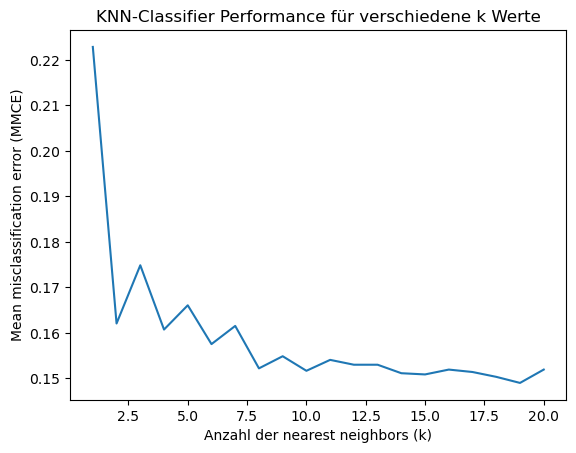

In [13]:
mean_scores = knn_gscv.cv_results_['mean_test_score']
plt.plot(np.arange(1, k_max + 1), 1.0 - mean_scores)
plt.xlabel('Anzahl der nearest neighbors (k)')
plt.ylabel('Mean misclassification error (MMCE)')
plt.title('KNN-Classifier Performance für verschiedene k Werte')
plt.show()

Nach dem Training kann man sich den besten Hyperparameter ausgeben lassen:

In [14]:
knn_gscv.best_params_

{'n_neighbors': 19}

In diesem Fall ist 19 der beste Parameter für k.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Vorhersagen für Testdaten treffen
knn_gscv_predicted_data = knn_gscv.predict(data_test)

# Auswertung der Vorhersage
knn_gscv_accuracy = accuracy_score(class_test, knn_gscv_predicted_data)
knn_gscv_f1_score = f1_score(class_test, knn_gscv_predicted_data)
print('Höchste erreichte Genauigkeit:', knn_gscv.best_score_)
print(f'Genauigkeit: {knn_gscv_accuracy}')
print(f'F1 score: {knn_gscv_f1_score}')

Höchste erreichte Genauigkeit: 0.8509734576120728
Genauigkeit: 0.8497576736672051
F1 score: 0.0970873786407767


Mithilfe der `accuracy_score`-Funktion wird die Genauigkeit der Vorhersage getroffen. Die `f1_score`-Funktion vereinigt die Metriken Präzision und Recall in eine Metrik. Präzision misst, wie genau das Modell positive Fälle aus allen vorhergesagten positiven Fällen identifiziert. Sie wird berechnet als die Anzahl der wahren positiven Ergebnisse geteilt durch die Summe aus wahren positiven und falsch positiven Ergebnissen. Recall (auch Sensitivität genannt) misst, wie gut das Modell alle positiven Fälle identifiziert. Er wird berechnet als die Anzahl der wahren positiven Ergebnisse geteilt durch die Summe aus wahren positiven und falsch negativen Ergebnissen.

Folglich wurde aus dem Datensatz ein optimales k mit dem Wert 19 ermittelt, welches eine Genauigkeit von $\sim$ 84.98% erreicht.

### 3.2 Support Vector Machine

### 3.2.1 Support Vector Machine (Linear-Kernel)

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc_classifier = SVC(kernel='linear', probability=True)
svc_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
svc_predicted_data = svc_classifier.predict(data_test)

# Auswertung der Vorhersage
svc_accuracy = accuracy_score(class_test, svc_predicted_data)
print(f'Genauigkeit: {svc_accuracy}')

[0 0 0 ... 0 0 0]
Genauigkeit: 0.8473344103392568


### 3.2.2 Support Vector Machine (RBF-Kernel)

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc_classifier = SVC(kernel='rbf', probability=True)
svc_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
svc_predicted_data = svc_classifier.predict(data_test)

# Auswertung der Vorhersage
svc_accuracy = accuracy_score(class_test, svc_predicted_data)
print(f'Genauigkeit: {svc_accuracy}')

[0 0 0 ... 0 0 0]
Genauigkeit: 0.8473344103392568


### 3.2.3 Support Vector Machine (Poly-Kernel)

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc_classifier = SVC(kernel='poly', probability=True)
svc_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
svc_predicted_data = svc_classifier.predict(data_test)

# Auswertung der Vorhersage
svc_classifier_f1_score = f1_score(class_test, svc_predicted_data)
svc_accuracy = accuracy_score(class_test, svc_predicted_data)
print(f'Genauigkeit: {svc_accuracy}')
print(f'F1 score: {svc_classifier_f1_score}')

[0 0 0 ... 0 0 0]
Genauigkeit: 0.8473344103392568
F1 score: 0.020725388601036267


Die Parameter des `SVC`-Methodenaufrufs:
* _kernel_ bestimmt welche Kernelfunktion verwendet wird, um die Eingabedaten in eine höhere Dimensionsebene abzubilden.
* _probability_ gibt an, ob der SVM-Algorithmus eine Wahrscheinlichkeitsschätzung für die Vorhersage der Klassenetiketten abgeben soll.

Beim obigen Beispiel wurde der Polynom-Kernel als Funktion verwendet. Lineare- und RBF-Kernel wurden ebenfalls untersucht, die jedoch dieselbe Genauigkeit aufweisen:

* linear $\sim$ 84.73%
* poly $\sim$ 84.73%
* rbf $\sim$ 84.73%
<br></br>

Auch hier wurde versucht `GridSearchCV` zu nutzen um die besten Hyperparameter zu finden. Jedoch wurde die Methode auch nach 75min Laufzeit nicht fertig, sodass wir uns entschieden haben bei SVM darauf zu verzichten.

### 3.3 Logistiche Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_classifier = LogisticRegression(random_state=1, max_iter=7000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

lr_classifier = GridSearchCV(lr_classifier, param_grid=param_grid, cv=5)
lr_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
lr_predicted_data = lr_classifier.predict(data_test)

# Auswertung der Vorhersage
lr_classifier.best_estimator_
lr_classifier_f1_score = f1_score(class_test, lr_predicted_data)
lr_accuracy = accuracy_score(class_test, lr_predicted_data)
print('Beste Parameter:', lr_classifier.best_params_)
print('Höchste erreichte Genauigkeit:', lr_classifier.best_score_)
print(f'Genauigkeit: {lr_accuracy}')
print(f'F1 score: {lr_classifier_f1_score}')

[0 1 0 ... 0 0 0]
Beste Parameter: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Höchste erreichte Genauigkeit: 0.85475196628991
Genauigkeit: 0.8497576736672051
F1 score: 0.11428571428571427


Die Parameter des `LogisticRegression`-Methodenaufrufs:
* *random_state* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.
* *max_iter* bestimmt die Anzahl von Iteration, die der *solver* durchführen soll, um zu konvergieren.

Die `LogisticRegression`-Hyperparameter die mithilfe von `GridSearchCV` untersucht werden:
* *penalty* wird verwendet, um die Art/Größenordnung des Strafterms, welche zur Kostenfunktion gehört, zu bestimmen.
* *C* bestimmt wie stark der Strafterm der Kostenfunktion ausfällt, wobei ein kleines *C* für einen hoher Strafwert und ein hohes *C* für einen kleinen Strafwert steht.
* *solver* bestimmt den Algorithmus der für das Lösen des Optimierungsproblems verwendet wird (default ist lbgfs).

Das Klassifikationsverfahren der Logistischen Regression ergibt eine Genauigkeit von $\sim$ 84.97%

### 3.4 Entscheidungsbäume

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=1)
param_grid = {
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [10, 20, 30]
}

dt_classifier = GridSearchCV(dt_classifier, param_grid=param_grid, cv=5)
dt_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
dt_predicted_data = dt_classifier.predict(data_test)

# Auswertung der Vorhersage
dt_classifier.best_estimator_
dt_classifier_f1_score = f1_score(class_test, dt_predicted_data)
dt_accuracy = accuracy_score(class_test, dt_predicted_data)
print('Beste Parameter:', dt_classifier.best_params_)
print('Höchste erreichte Genauigkeit:', dt_classifier.best_score_)
print(f'Genauigkeit: {dt_accuracy}')
print(f'F1 score: {dt_classifier_f1_score}')

[0 0 0 ... 0 0 0]
Beste Parameter: {'max_depth': 1, 'min_samples_leaf': 10}
Höchste erreichte Genauigkeit: 0.8475933245150611
Genauigkeit: 0.8473344103392568
F1 score: 0.0


Die Parameter des `DecisionTreeClassifier`-Methodenaufrufs:
* *random_state* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.

Bei diesem Aufruf wird per default Gini bzw. der Information-Gain als Kriterium für die Ermittlung der besten Splitter verwendet.
<br></br>

Die `DecisionTreeClassifier`-Hyperparameter die mithilfe von `GridSearchCV` untersucht werden:
* *max_depth* legt die maximale Tiefe des Baumes fest.
* *min_samples_leaf* steht für die Mindestanzahl an Daten die in Blättern vorhanden sein müssen (wird für bei der Erstellung von Splits berücksichtigt).


Dieser Entscheidungsbaum liefert eine Genauigkeit von $\sim$ 84.73%

### 3.5 Ensemble von Entscheidungsbäumen

Hierzu werden drei verschiedene Ansätze für diese Art von Klassifikationsverfahren verwendet.

### 3.5.1 Random Forests (Bagging)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf_classifier = RandomForestClassifier(random_state=1)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [10, 20, 30],
    'bootstrap': [True, False]
}

rf_classifier = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5)
rf_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
rf_predicted_data = rf_classifier.predict(data_test)

# Auswertung der Vorhersage
rf_classifier.best_estimator_
rf_classifier_f1_score = f1_score(class_test, rf_predicted_data)
rf_accuracy = accuracy_score(class_test, rf_predicted_data)
print('Beste Parameter:', rf_classifier.best_params_)
print('Höchste erreichte Genauigkeit:', rf_classifier.best_score_)
print(f'Genauigkeit: {rf_accuracy}')
print(f'F1 score: {rf_classifier_f1_score}')

[0 1 0 ... 0 0 0]
Beste Parameter: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 50}
Höchste erreichte Genauigkeit: 0.8527670629608801
Genauigkeit: 0.8489499192245558
F1 score: 0.06030150753768844


Die Parameter des `RandomForestClassifier`-Methodenaufrufs:
* *random_state* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.

Bei diesem Aufruf wird per default Gini bzw. der Information-Gain als Kriterium für die Ermittlung der besten Splitter verwendet.
<br></br>

Die `RandomForestClassifier`-Hyperparameter die mithilfe von `GridSearchCV` untersucht werden:
* *max_depth* legt die maximale Tiefe des Baumes fest.
* *min_samples_leaf* steht für die Mindestanzahl an Daten die in Blättern vorhanden sein müssen (wird für bei der Erstellung von Splits berücksichtigt).
* *n_estimators* legt die Anzahl der Base-Learner für das Ensembles fest.
* *bootstrap* bestimmt ob die Base-Learner mit zufällig gewählten Datasets trainiert werden sollen.

Klassifikationsverfahren Ensemble von Random Forests (Bagging) ergibt eine Genauigkeit von $\sim$ 84.89%

### 3.5.2 AdaBoost (Adaptive Boosting)

In [25]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(random_state=1)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_classifier = GridSearchCV(adaboost_classifier, param_grid=param_grid, cv=5)
adaboost_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
adaboost_predicted_data = adaboost_classifier.predict(data_test)


# Auswertung der Vorhersage
adaboost_classifier.best_estimator_
adaboost_classifier_f1_score = f1_score(class_test, adaboost_predicted_data)
adaboost_accuracy = accuracy_score(class_test, adaboost_predicted_data)
print('Beste Parameter:', adaboost_classifier.best_params_)
print('Höchste erreichte Genauigkeit:', adaboost_classifier.best_score_)
print(f'Genauigkeit: {adaboost_accuracy}')
print(f'F1 score: {adaboost_classifier_f1_score}')

[0 1 0 ... 0 0 0]
Beste Parameter: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Höchste erreichte Genauigkeit: 0.8515694676562141
Genauigkeit: 0.8441033925686591
F1 score: 0.11059907834101382


Die Parameter des `AdaBoostClassifier`-Methodenaufrufs:
* *random_state* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.

Bei diesem Aufruf wird per default ein *DecisionTreeClassifier* als *base_estimator* (legt den Typ des Base-Learners fest) mit der *max_depth* von 1 verwendet.
<br></br>

Die `AdaBoostClassifier`-Hyperparameter die mithilfe von `GridSearchCV` untersucht werden:
* *n_estimators* legt die Anzahl der Base-Learner für das Ensembles fest.
* *learning_rate* bestimmt, ob die Base-Learner mit zufällig gewählten Datasets trainiert werden sollen.
* *algorithm* bestimmt den zu verwendenden Algorithmus der zur gewichtung der Weak-Learner genutzt wird.

Klassifikationsverfahren Ensemble von AdaBoost (Adaptive Boosting) ergibt eine Genauigkeit von $\sim$ 84.41%

### 3.5.3 Ensemble-Methoden – Stacking

In [26]:
from sklearn.ensemble import StackingClassifier

# Liste der Base-Learner/Schätzverfahren
estimators = [
    ('rf', rf_classifier),
    ('dt', dt_classifier),
]

# Zuweisung des Meta-Schätzverfahrens
meta_estimator = lr_classifier

# Instanziierung des Stacking-CLassifiers mit den verschiedenen Schätzverfahren
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)
stacking_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
stacking_predicted_data = stacking_classifier.predict(data_test)

# Auswertung der Vorhersage
stacking_classifier_f1_score = f1_score(class_test, stacking_predicted_data)
stacking_accuracy = accuracy_score(class_test, stacking_predicted_data)
print(f'Genauigkeit: {stacking_accuracy}')
print(f'F1 score: {stacking_classifier_f1_score}')

Genauigkeit: 0.8465266558966075
F1 score: 0.10377358490566037


Die Parameter des `StackingClassifier`-Methodenaufrufs:
* *estimators* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.
* *final_estimator* legt den Typ des letzen Base-Learners fest, welcher den Input der vorhergehenden Base-Learnern erhält.

Stacking ergibt eine Genauigkeit von $\sim$ 84.65%

### 3.6 Multilayer Perceptron (Neuronalen Netzen)

In [27]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(random_state=1, max_iter=1000)
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (50, 50), (20, 20, 20)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp_classifier = GridSearchCV(mlp_classifier, param_grid=param_grid, cv=5)
mlp_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
mlp_predicted_data = mlp_classifier.predict(data_test)

# Auswertung der Vorhersage
mlp_classifier.best_estimator_
mlp_classifierr_f1_score = f1_score(class_test, mlp_predicted_data)
mlp_accuracy = accuracy_score(class_test, mlp_predicted_data)
print('Beste Parameter:', mlp_classifier.best_params_)
print('Höchste erreichte Genauigkeit:', mlp_classifier.best_score_)
print(f'Genauigkeit: {mlp_accuracy}')
print(f'F1 score: {mlp_classifierr_f1_score}')

[0 0 0 ... 0 0 0]
Beste Parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
Höchste erreichte Genauigkeit: 0.8515686755958274
Genauigkeit: 0.8449111470113085
F1 score: 0.1272727272727273


Die Parameter des `MLPClassifier`-Methodenaufrufs:
* *random_state* stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit.
* max_iter bestimmt die Anzahl von Iteration, die der *solver* durchführen soll, um zu konvergieren.
<br></br>

Die `MLPClassifier`-Hyperparameter die mithilfe von `GridSearchCV` untersucht werden:
* *hidden_layer_sizes* legt die Anzahl an Neuronen für jedes Layer fest. Dabei steht jeder Wert der in dem übergebenem Tupel steht für einen Hidden-Layer. 
* *activation* steht für die Aktivierungsfunktion die für die Hidden-Layer verwendet werden soll.
* *solver* bestimmt den Optimierungslgorithmus der für das Tranieren des Netzwerks verwendet werden soll.
* *alpha* gibt den Regulierungsparameter an.
* *learning_rate* bestimmt wie die Gewichte angepasst werden sollen.

Das Ensemble Neuronaler Netze (Multilayer Perceptron) erreicht eine Genauigkeit von $\sim$ 84.49%

### 3.7 Beurteilung der Ergebnisse unserer Klassifikationen

Wo möglich beziehungsweise Sinnvoll, im Bezug auf die Rechenzeit, wurde die Methode `GridSearchCV` verwendet, um die besten Hyperparameter für die einzelnen Klassifikationsverfahren zu ermitteln. Zusammenfassend werden noch einmal alle untersuchte Klassifikationsverfahren aufgelistet:
* `k-NN`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.98%
* `SVM (Linear-, RBF- und Poly-Kernel)`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.73%
* `Logistische Reggresion`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.97%
* `Entscheidungsbäume`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.73%
* `Ensembles von Entscheidungsbäumen`:
    * `Random Forests (Bagging)`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.89%
    * `AdaBoost (Boosting)`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.41%
    * `Stacking`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.65%
* `Multilayer-Perceptron (MLP)`: lieferte eine Klassifikationsgenauigkeit von $\sim$ 84.49%

Die Ergebnisse aus den oben verschiedenen Klassifikationsverfahren sind im Prinzip sehr ähnlich und unterscheiden sich nur gering im Bezug zu ihrer Klassifikationsgenauigkeit.

**=>** Nchtsdestotrotz ist ***k-NN das geeignetste Klassifikationsverfahren für den gewählten Datensatz***.

## 4.  Abschätzung der Bedeutung der einzelnen Feature bzgl. der Klassifikation

Zur Erinnerung, werden die betrachteten Parameter für die Vorhersage der Risikoklasse im Folgenden wieder dargestellt. Dies ist wichtig, da die nächsten Methoden die Ergebnisse in einem Array ausgeben, welches den Indizes des Arrays der Parameters entspricht. In diesem Abschnitt wird die Feature-Importance für die vielversprechendsten Klassifikationsverfahren ermittelt.

In [28]:
parameters = data[['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel']]

### 4.1 Feature Importances -- Random Forests (Bagging)

Diese Methode berechnet die Wichtigkeit jedes Merkmals in einem Random-Forests-Classifier. Das Attribut _feature_importances_ eines trainierten Random-Forests-Classifiers kann verwendet werden, um die Werte für die Wichtigkeit der Merkmale zu erhalten.

In [29]:
# Ermitteln der Feature Importances der Parameter
feature_importances = rf_classifier.best_estimator_.feature_importances_
print(feature_importances)
print(sum(feature_importances))

[0.03990369 0.19672937 0.01462038 0.04833916 0.00202005 0.00123326
 0.04208404 0.01293349 0.08418314 0.16820568 0.10522035 0.10878845
 0.06041969 0.11531925]
1.0


Hier gilt, dass die Parameter die näher an der 1.0 liegen einen höheren Einfluss auf das Modell hat.

Die 5 Parameter mit dem Abstand größten Einfluss im Vergleich zu den anderen sind:
* Alter: 0.1967 => $\sim$ 19.67% Anteil der Gesamt-Importance
* Systole: 0.1682 => $\sim$ 16.82% Anteil der Gesamt-Importance
* Blutglukosespiegel: 0.1153 => $\sim$ 11.53% Anteil der Gesamt-Importance
* BMI: 0.1088 => $\sim$ 10.88% Anteil der Gesamt-Importance
* Diastole: 0.1052 => $\sim$ 10.52% Anteil der Gesamt-Importance

### 4.2 Permutation Feature Importance -- Random Forests (Bagging)

Bei dieser Methode werden die Werte der einzelnen Merkmale nach dem Zufallsprinzip vertauscht und die Auswirkungen auf die Modellleistung gemessen. Die Funktion `permutation_importance` aus dem Modul **sklearn.inspection** kann hierzu verwendet werden.

In [30]:
from sklearn.inspection import permutation_importance

# Ermitteln der Feature Importances der Parameter
result = permutation_importance(rf_classifier, data_test, class_test, n_repeats=10, random_state=1)

# Ausgabe der Feature Importances
print('Feature Importances: ', result.importances_mean)

Feature Importances:  [ 2.26171244e-03  1.69628433e-03 -1.29240711e-03  2.10016155e-03
  8.07754443e-05  0.00000000e+00  8.07754443e-04  0.00000000e+00
  1.77705977e-03  2.42326333e-03  1.53473344e-03 -8.07754443e-05
  2.18093700e-03  2.42326333e-03]


Ein höherer Wert von _importances_mean_ für ein bestimmtes Merkmal zeigt an, dass die Leistung des Modells empfindlicher auf Änderungen dieses Merkmals reagiert und das Merkmal daher als wichtiger eingestuft wird.

Die wichtigsten positiven Parameter sind:
* Raucher / Schlaganfall / Diabetes
* Puls
* Geschlecht
<br></br>

Die wichtigsten negativen Parameter sind:
* Alter
* Blutdrucksenker
* BMI
* Systole

=> Alle positiven Parameter führen zu einer positiven Klassifizierung (1), während negative Parameter eine negative Klassifizierung (0), im Bezug zur Risikoklasse, erzielen. ***Infolgedessen sind für unseren Anwendungsfall die positiven Parameter interessant***.


### 4.3 Permutation Feature Importance -- Logistische Regression

In [31]:
# Ermitteln der Feature Importances der Parameter
result = permutation_importance(lr_classifier, data_test, class_test, n_repeats=10, random_state=1)

# Ausgabe der Feature Impotrances
print('Feature Importances: ', result.importances_mean)

Feature Importances:  [ 0.00258481  0.00468498  0.          0.00420032  0.          0.00040388
 -0.00153473  0.          0.00113086  0.00436187  0.00153473  0.
  0.00153473  0.00549273]


Die wichtigsten positiven Parameter sind:
* Blutglukosespiegel
* Alter
* Systole
* Zigaretten_pro_Tag
* Schlaganfall

### 4.4 k-NN -- Permutation Feature Importance

In [32]:
# Ermitteln der Feature Importances der Parameter
result = permutation_importance(knn_gscv, data_test, class_test, n_repeats=10, random_state=1)

# Ausgabe der Feature Impotrances
print('Feature Importances: ', result.importances_mean)

Feature Importances:  [0.         0.00129241 0.         0.00218094 0.         0.
 0.         0.         0.00452342 0.00193861 0.00169628 0.00121163
 0.00129241 0.00678514]


Ein höherer Wert von _importances_mean_ für ein bestimmtes Merkmal zeigt an, dass die Leistung des Modells empfindlicher auf Änderungen dieses Merkmals reagiert und das Merkmal daher als wichtiger eingestuft wird.

Die wichtigsten Parameter sind:
* Blutglukosespiegel
* Gesamtcholesterin
* Zigaretten_pro_Tag
* Systole
* Diastole

### 4.5 Beurteilung der Feature-Importance Ergebnisse

Bei der Ermittlung der Feature-Importance gab es beispielsweise bei Random Forests bereits ein geeignetes Attribut, welches ein Array mit den bewerteten Features bereitgestellt hat. Für die anderen Klassifikationsverfahren konnte die Feature-Importance mithilfe der `permutation_importance`-Funktion ermittelt werden.
<br></br>

Folgende klinische Parameter wurden von den jeweiligen Klassifikationsverfahren als wichtigste Features ausgegeben:

k-NN - Permutation Importance:
* Blutglukosespiegel
* Gesamtcholesterin
* Zigaretten_pro_Tag
* Systole
* Diastole

Logistische Regression - Permutation Importance:
* Blutglukosespiegel
* Alter
* Systole
* Zigaretten_pro_Tag
* Schlaganfall

Random Forests (Bagging) - Permutation Importance:
* Raucher / Schlaganfall / Diabetes
* Puls
* Geschlecht


Random Forests (Bagging) - Feature Importance:
* Alter: 0.1967 => $\sim$ 19.67% Anteil der Gesamt-Importance
* Systole: 0.1682 => $\sim$ 16.82% Anteil der Gesamt-Importance
* Blutglukosespiegel: 0.1153 => $\sim$ 11.53% Anteil der Gesamt-Importance
* BMI: 0.1088 => $\sim$ 10.88% Anteil der Gesamt-Importance
* Diastole: 0.1052 => $\sim$ 10.52% Anteil der Gesamt-Importance
<br></br>


Folgende Parameter wurden am häufigsten genannt:
* Systole kommt bei k-NN, Logistischer Regression, und Random Forests (Feature-Importance) vor.
* Diastole kommt bei der Logistischen Regression und Random Forests (Feature Importance) vor.
* Blutglukosespiegel kommt bei k-NN, Logistischer Regression, und Random Forests (Feature-Importance) vor.
* Schlaganfall kommt bei der Logistischen Regression und Random Forests (Permutation Importance) vor.
* Zigaretten_pro_Tag kommt bei k-NN und Logistischer Regression vor.
<br></br>
 
Auffällig ist, dass die Attribute *feature_importance* und *importances_mean*, sich bei den ermittelten Features unterscheiden. Das liegt an der Art und Weiße, wie die Importance in den entsprechenden Funktionen berechnet wird. Die *feature_importance* wird anhand der Impurity-Reduktion ermittelt. Daher sind Features, die für eine hohe Reduktion der Impurity sorgen, wichtiger als Features, die zu einer geringen Reduktion führen. Bei der Berechnung des *importances_mean* wird zuerst eine Baseline-Klassifizierung vorgenommen, die als Vergleichswert für die darauf folgenden Klassifizierungen verwendet wird. Anschließend wird in jeder nachfolgenden Iteration der Performanceverlust gemessen. Aus diesem wird ein Mittelwert gebildet, welcher zur Bestimmung der Feature-Importances verwendet wird [1].

In Anbetracht der Ergebnisse ergeben Features wie Systole, Diastole, Blutglukosespiegel, Schlaganfall und Zigaretten_pro_Tag für **uns** am meisten Sinn. Im Folgenden Abschnitt werden die klinischen Parameter anhand einer Korrelationsmatrix auf deren Korrelation geprüft, um so einen anderen Blick auf deren Einfluss zu bekommen. Die daraus ermittelten Parameter bilden ein neues Feature-Set, welches in einer neuen Klassifikationsiteration mit den 3 besten Klassifikationsverfahren zur Klassifizierung verwendet wird.

## 5. Klassifikationsverfahren auf einem veränderten Feature-Set (Feature-Engineering)

Da durch den Ansatz von PCA und t-SNE keine potenziell gute Separierbarkeit der Klassen abgelesen werden konnte, wird versucht, die Dimension des Datensatzes mithilfe der Korrelationsmatrix zu reduzieren.

### Korrelationsmatrix

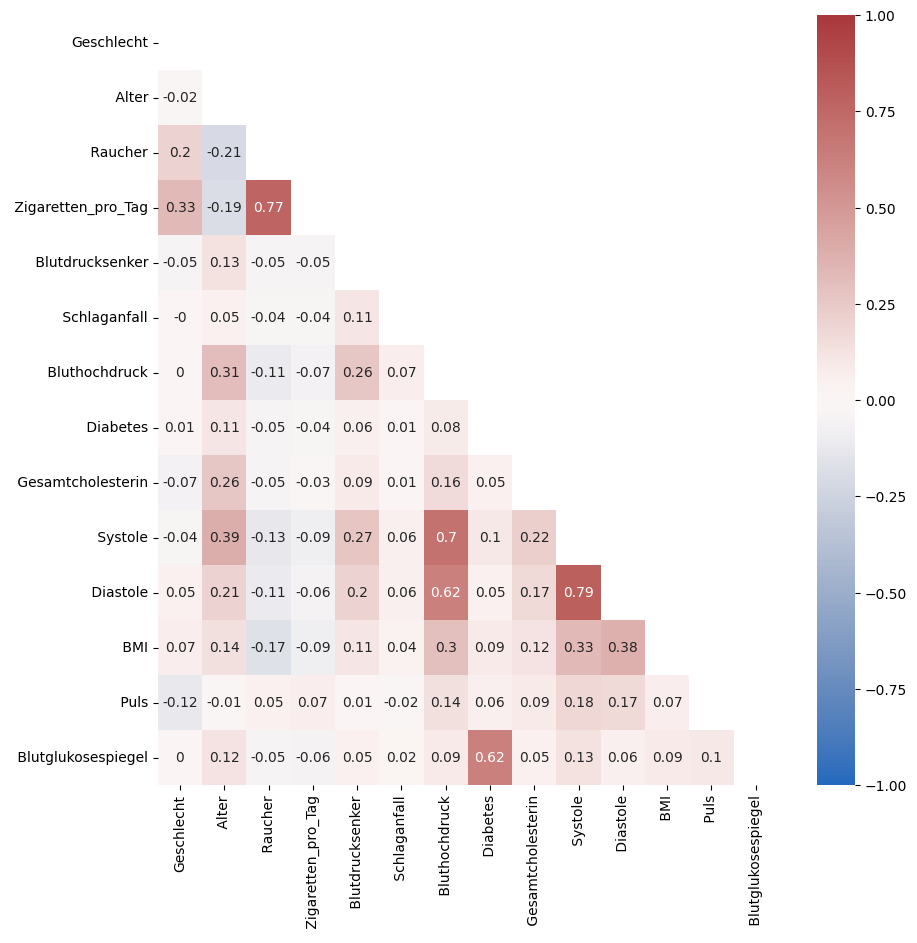

In [33]:
import seaborn as sns

matrix = data.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

Die Nummern in der Korrelationsmatrix geben den Wert des Korrelationskoeffizienten an. Ein Wert von 1 zeigt an, dass es eine perfekte positive Korrelation zwischen den beiden Variablen gibt, während ein Wert von -1 darauf hinweist, dass es eine perfekte negative Korrelation gibt. Ein Wert von 0 bedeutet, dass es keine Korrelation zwischen den Variablen gibt. Oben wurden die Korrelationen mit verschiedenen Farben dargestellt, um den Grad des Zusammenhangs zwischen den Variablen zu visualisieren. Eine starke positive Korrelation wird durch Dunkelrot dargestellt, während eine starke negative Korrelation durch Dunkelblau.

Die Koeffizienten, deren Betrag dem Wert 1 am nächsten liegt, werden für eine neue Dimensionierung des Datensatzes berücksichtigt. Die Parameter, die einen wesentlichen Einfluss auf die Risikoklasse haben, werden im Folgenden aufgeführt:
* Diastole - Systole: 0.79
* Zigaretten_pro_Tag - Raucher: 0.77
* Systole - Bluthochdruck: 0.7
* Diastole - Bluthochdruck: 0.62
* Blutglukosespiegel - Diabetes: 0.62

Mit diesen Parametern ergibt sich eine neue Dimension des Datensatzes, um eine möglichst gute Vorhersage für die (Risiko-)Klassifikation zu erreichen. Die anderen klinischen Parameter scheinen keine großen Auswirkung auf die Klassifizierung zu besitzen, wenn sie verändert werden. Infolgedessen bilden diese Parameter das neue veränderte Feature-Set:

In [34]:
new_parameters_set = data[[' Raucher', ' Zigaretten_pro_Tag',
       ' Bluthochdruck', ' Diabetes',
       ' Systole', ' Diastole', ' Blutglukosespiegel']]

### Erstellung des neuen Feature-Sets

In [35]:
new_data_train, new_data_test, new_class_train, new_class_test = \
    train_test_split(new_parameters_set, classification, test_size=0.33, random_state=1, stratify=classification)

### Skalieren des Feature-Sets

Hierzu werden verschiedene Scaling-Funktionen wie `StandardScaler`, `MinMaxScaler` und `RobustScaler` aus dem **sklearn.processing**-Modul verwendet. Im Folgenden verden die Scaler kurz erklärt:
* `StandardScaler`: Normalisiert die Featuresm in dem es den Datensatz normalisiert. Somit ergibt sich ein Mittelwert von 0 und eine Varianz von 1 [2].

* `MinMaxScaler`: Transformiert jedes einzelne Feature, durch Skalierung, in eine vorgegebene Range bswp. [0,1]. Features die einen negativen Wert aufweisen, werden auch in diese Range gedrückt/geshiftet. Hierbei wird der kleinste Wert im Datensatz zur 0 und die anderen Werte werden in die angegebene Range skaliert [2].

* `RobustScaler`: Skaliert den Datensatz zu einer vorgegebenen Quantil-Range. In der Regel wird hierfür eine Interquartil-Range verwendet. Von jedem Datenwert wird der Median subtrahiehrt und im Anschluss durch de Interquartil-Range geteilt. [3]

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Skalieren der Daten (eine zweiter Art die Features zu engineeren)
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

data_train_s_scaled = standard_scaler.fit_transform(new_data_train)
data_test_s_scaled = standard_scaler.fit_transform(new_data_test)

data_train_mm_scaled = minmax_scaler.fit_transform(new_data_train)
data_test_mm_scaled = minmax_scaler.fit_transform(new_data_test)

data_train_r_scaled = robust_scaler.fit_transform(new_data_train)
data_test_r_scaled = robust_scaler.fit_transform(new_data_test)

### 5.1 Neue Iteration mit reduziertem skalierten Features-Set

### 5.1.1 k-NN Iteration mit den unterschiedlich skalierten Feature-Sets

In [37]:
knn_gscv.fit(data_train_s_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
knn_gscv_predicted_data_scaled = knn_gscv.predict(data_test_s_scaled)

# Auswertung der Vorhersage
knn_gscv_f1_score = f1_score(class_test, knn_gscv_predicted_data_scaled)
knn_gscv_accuracy_scaled = accuracy_score(new_class_test, knn_gscv_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {knn_gscv_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {knn_gscv_accuracy_scaled}')
print(f'F1 score: {knn_gscv_f1_score}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.8489499192245558
F1 score: 0.07881773399014778


In [38]:
knn_gscv.fit(data_train_mm_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
knn_gscv_predicted_data_scaled = knn_gscv.predict(data_test_mm_scaled)

# Auswertung der Vorhersage
knn_gscv_accuracy_scaled = accuracy_score(new_class_test, knn_gscv_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {knn_gscv_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {knn_gscv_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.8416801292407108


In [39]:
knn_gscv.fit(data_train_r_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
knn_gscv_predicted_data_scaled = knn_gscv.predict(data_test_r_scaled)

# Auswertung der Vorhersage
knn_gscv_accuracy_scaled = accuracy_score(new_class_test, knn_gscv_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {knn_gscv_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {knn_gscv_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.8416801292407108


### 5.1.2 Logistische Regression mit den unterschiedlich skalierten Feature-Sets

In [40]:
lr_classifier.fit(data_train_s_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
lr_predicted_data_scaled = knn_gscv.predict(data_test_s_scaled)

# Auswertung der Vorhersage
lr_accuracy_scaled = accuracy_score(new_class_test, lr_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {lr_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {lr_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.8384491114701131


In [41]:
lr_classifier.fit(data_train_mm_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
lr_predicted_data_scaled = lr_classifier.predict(data_test_mm_scaled)

# Auswertung der Vorhersage
lr_accuracy_scaled = accuracy_score(new_class_test, lr_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {lr_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {lr_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.8360258481421647


In [42]:
lr_classifier.fit(data_train_r_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
lr_predicted_data_scaled = lr_classifier.predict(data_test_r_scaled)

# Auswertung der Vorhersage
lr_classifier_f1_score = f1_score(class_test, lr_predicted_data_scaled)
lr_accuracy_scaled = accuracy_score(new_class_test, lr_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {lr_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {lr_accuracy_scaled}')
print(f'F1 score: {lr_classifier_f1_score}')

Genauigkeit mit originalen Features: 0.8497576736672051
Genauigkeit mit skalierten reduziertem Features-Set: 0.845718901453958
F1 score: 0.0861244019138756


### 5.1.3 Random Forests mit den unterschiedlich skalierten Feature-Sets

In [43]:
rf_classifier.fit(data_train_s_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
rf_predicted_data_scaled = knn_gscv.predict(data_test_s_scaled)

# Auswertung der Vorhersage
rf_accuracy_scaled = accuracy_score(new_class_test, rf_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {rf_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {rf_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8489499192245558
Genauigkeit mit skalierten reduziertem Features-Set: 0.8384491114701131


In [44]:
rf_classifier.fit(data_train_mm_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
rf_predicted_data_scaled = knn_gscv.predict(data_test_mm_scaled)

# Auswertung der Vorhersage
rf_classifier_f1_score = f1_score(class_test, rf_predicted_data_scaled)
rf_accuracy_scaled = accuracy_score(new_class_test, rf_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {rf_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {rf_accuracy_scaled}')
print(f'F1 score: {rf_classifier_f1_score}')

Genauigkeit mit originalen Features: 0.8489499192245558
Genauigkeit mit skalierten reduziertem Features-Set: 0.8473344103392568
F1 score: 0.0


In [45]:
rf_classifier.fit(data_train_r_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
rf_predicted_data_scaled = knn_gscv.predict(data_test_r_scaled)

# Auswertung der Vorhersage
rf_accuracy_scaled = accuracy_score(new_class_test, rf_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {rf_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {rf_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8489499192245558
Genauigkeit mit skalierten reduziertem Features-Set: 0.8416801292407108


### 5.1.4 MLP mit den unterschiedlich skalierten Feature-Sets

In [46]:
mlp_classifier.fit(data_train_s_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
mlp_predicted_data_scaled = mlp_classifier.predict(data_test_s_scaled)

# Auswertung der Vorhersage
mlp_accuracy_scaled = accuracy_score(new_class_test, mlp_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {mlp_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {mlp_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8449111470113085
Genauigkeit mit skalierten reduziertem Features-Set: 0.8449111470113085


In [47]:
mlp_classifier.fit(data_train_mm_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
mlp_predicted_data_scaled = mlp_classifier.predict(data_test_mm_scaled)

# Auswertung der Vorhersage
mlp_accuracy_scaled = accuracy_score(new_class_test, mlp_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {mlp_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {mlp_accuracy_scaled}')

Genauigkeit mit originalen Features: 0.8449111470113085
Genauigkeit mit skalierten reduziertem Features-Set: 0.8408723747980614


In [48]:
mlp_classifier.fit(data_train_r_scaled, new_class_train)

# Vorhersagen mit skalierten Testdaten
mlp_predicted_data_scaled = mlp_classifier.predict(data_test_r_scaled)

# Auswertung der Vorhersage
mlp_classifier_f1_score = f1_score(class_test, mlp_predicted_data_scaled)
mlp_accuracy_scaled = accuracy_score(new_class_test, mlp_predicted_data_scaled)
print(f'Genauigkeit mit originalen Features: {mlp_accuracy}')
print(f'Genauigkeit mit skalierten reduziertem Features-Set: {mlp_accuracy_scaled}')
print(f'F1 score: {mlp_classifier_f1_score}')

Genauigkeit mit originalen Features: 0.8449111470113085
Genauigkeit mit skalierten reduziertem Features-Set: 0.8465266558966075
F1 score: 0.14414414414414414


### 5.2 Bewertung der neuen Klassifikationsiteration

Als letzes Beispiel wurde das Klassifikationsverfahren Multilayer Perceptron (Neuronale Netze) verwendet. Dabei ist das Feature-Set, welches durch die `RobustScaler`-Methode skaliert wurde, das einzige, dass das Klassifikationsergebnis positiv beeinflusst hat. Daher wurde die Leistung sowohl durch eine Analyse der Korrelationsmatrix bzw. einer Dimensionreduktion der Features als auch durch das Skalieren des Feature-Sets etwas verbessert:
* mit originalen Features $\sim$ 84.17 %
* mit skalierten reduzierten Features-Set $\sim$ 84.65 %
<br></br>

Bei den anderen, vielversprechenden, Klassifikationsverfahren hat sich die Performance verschlechtert. Aus diesem Grund, kann man zusammenfassen, dass:
* Die Daten nicht immer von einer Skalierung profitieren. Nicht alle Datensätze erfordern eine Skalierung der Merkmale und einige Datensätze können sogar schlechter abschneiden, wenn sie skaliert werden.
* Nicht alle Skalierungsmethoden eignen sich.
* Modelle reagieren möglicherweise nicht, oder nur geringfügig auf die Skalierung von Merkmalen.
* Es ist besser, mit verschiedenen Vorverarbeitungsansätze zu experimentieren und ihre Leistung zu vergleichen, um den besten Ansatz für den Datensatz und das Modell zu finden.
<br></br>

Letztendlich konnte man in dieser und der vorherigen Iteration feststellen, dass es eine große Diskrepanz zwischen der Genauigkeit und dem F1 score gibt. Das lässt darauf schließen, dass der Datensatz unausgeglichen ist. Das liegt vor allem an den vielen 0 Werten des Datensatzes, was dazu führt, dass die Modelle einen Bias, im Bezug auf die Parameter bekommen, die wenige 0 Werte aufweisen. Das führt dazu, dass in Fällen, in denen der Wert eines Parameters nicht null ist, diese oft falsch klassifiziert werden.


# Quellen
* [1] C. Molnar. „8.6 Global Surrogate | Interpretable Machine Learning.” https://christophm.github.io/interpretable-ml-book/global.html (Zugriff am: 01. April 2023).
* [2] B. Roy. „All about Feature Scaling - Towards Data Science.” https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35 (Zugriff am: 02. April 2023).
* [3] J. Hale, „Scale, Standardize, or Normalize with Scikit-Learn - Towards Data Science,“ Towards Data Science, 03. April 2019. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 (Zugriff am: 02. April 2023).